In [1]:
import os
import sys
sys.path = ['efficientnet-b0-08094119.pth'] 

import time
import skimage.io
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from warmup_scheduler import GradualWarmupScheduler
from efficientnet_pytorch import model as enet
import albumentations
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from tqdm import tqdm_notebook as tqdm 
#import enet_model
#import enet_utils 
import warnings
warnings.filterwarnings("ignore") 

In [2]:
df_train = pd.read_csv('train.csv')
image_folder = os.path.join('train_images')

kernel_type = 'effnet_b0'

enet_type = 'efficientnet-b0'
fold = 0
tile_size = 256
image_size = 256
n_tiles = 12
batch_size = 2
num_workers = 4
out_dim = 5
init_lr = 3e-4 
warmup_factor = 10

warmup_epo = 1
n_epochs = 20
device = torch.device('cuda') 

In [3]:
skf = StratifiedKFold(4, shuffle=True, random_state=42)
df_train['fold'] = -1
for i, (train_idx, valid_idx) in enumerate(skf.split(df_train, df_train['isup_grade'])):
    df_train.loc[valid_idx, 'fold'] = i
df_train.head()

,image_id,data_provider,isup_grade,gleason_score,fold
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,3
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,2
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,3
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,3


In [4]:
pretrained_model = {'efficientnet-b0': 'efficientnet-b0-08094119.pth'}

class enetv2(nn.Module):
    def __init__(self, backbone, out_dim):
        super(enetv2, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        self.enet.load_state_dict(torch.load(pretrained_model[backbone]))

        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.extract(x)
        x = self.myfc(x)
        return x 

The following tiling function performs these steps: 

1. It finds the values we should pad H and W so that the dimensions are multiple of the size
2. it pads the image with constant values 
3. Reshapes the images into an array 
4. Swaps the order so that the dims would be in the right order and reshapes in order to have  a shape like this: numb x (numb x numb x numb) 
5. If the image has less than N tiles it gets padded to fit 
6. It Reshapes, it sums along the row so to get the tiles with the lowest sum, it orders them in ascending order and returns the index of the N smallest values. Then it selects those tiles which are the ones with more tissue regions, cause at a lower sum corresponds more tissue, and finally it lists them 

In [5]:
from PIL import Image 

In [6]:
def get_tiles(img):
        tiles = []
        H, W, C = img.shape
        #1
        pad_H = (tile_size - H % tile_size) % tile_size 
        pad_W = (tile_size - W % tile_size) % tile_size 
        #2
        img2 = np.pad(img,[[pad_H // 2, pad_H - pad_H // 2], [pad_W // 2,pad_W - pad_W//2], 
                            [0,0]], constant_values=255)
        
        #3
        img3 = img2.reshape(
            img2.shape[0] // tile_size,
            tile_size,
            img2.shape[1] // tile_size,
            tile_size,
            3)
        #4
        img3 = img3.transpose(0,2,1,3,4).reshape(-1, tile_size, tile_size,3)
        n_tiles_with_info = (img3.reshape(img3.shape[0],-1).sum(1) < tile_size ** 2 * 3 * 255).sum()
        #5
        if len(img3) < n_tiles:
            img3 = np.pad(img3,[[0,n_tiles-len(img3)],[0,0],[0,0],[0,0]], constant_values=255)
        #6
        idxs = np.argsort(img3.reshape(img3.shape[0],-1).sum(-1))[:n_tiles]
        img3 = img3[idxs]
        for i in range(len(img3)):
            tiles.append({'img':img3[i], 'idx':i})
        return tiles, n_tiles_with_info >= n_tiles  

In [7]:
class PANDADataset(Dataset):
    def __init__(self,
                 df,
                 image_size,
                 n_tiles=n_tiles,
                 rand=False,
                 transform=None,
                ):

        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.n_tiles = n_tiles
        self.rand = rand
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.image_id
        
        tiff_file = os.path.join(image_folder, f'{img_id}.tiff')
        image = skimage.io.MultiImage(tiff_file)[1]
        tiles, OK = get_tiles(image)

        if self.rand:
            idxes = np.random.choice(list(range(self.n_tiles)), self.n_tiles, replace=False)
        else:
            idxes = list(range(self.n_tiles))

        n_row_tiles = int(np.sqrt(self.n_tiles))
        images = np.zeros((image_size * n_row_tiles, image_size * n_row_tiles, 3))
        for h in range(n_row_tiles):
            for w in range(n_row_tiles):
                i = h * n_row_tiles + w
    
                if len(tiles) > idxes[i]:
                    this_img = tiles[idxes[i]]['img']
                else:
                    this_img = np.ones((self.image_size, self.image_size, 3)).astype(np.uint8) * 255
                this_img = 255 - this_img
                if self.transform is not None:
                    this_img = self.transform(image=this_img)['image']
                h1 = h * image_size
                w1 = w * image_size
                images[h1:h1+image_size, w1:w1+image_size] = this_img

        if self.transform is not None:
            images = self.transform(image=images)['image']
        images = images.astype(np.float32)
        images /= 255
        images = images.transpose(2, 0, 1)

        label = np.zeros(5).astype(np.float32)
        label[:row.isup_grade] = 1.
        return torch.tensor(images), torch.tensor(label)

In [8]:
transforms_train = albumentations.Compose([
    albumentations.Transpose(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
])
transforms_val = albumentations.Compose([])

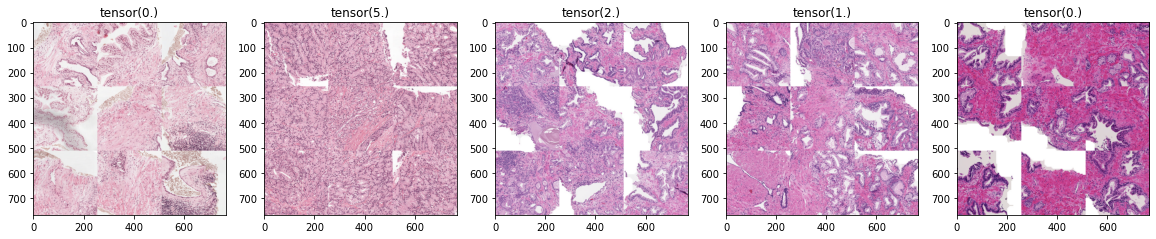

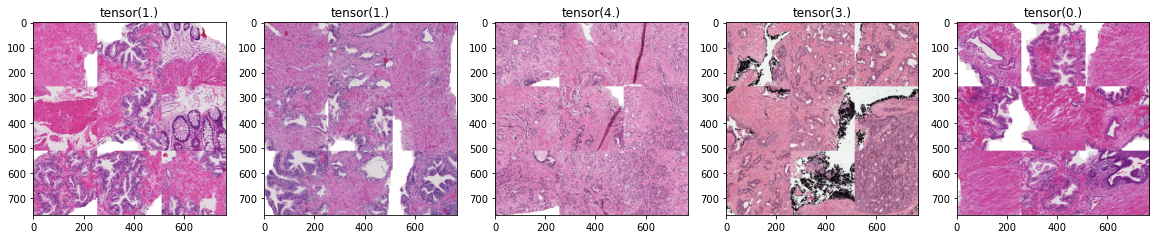

In [9]:
dataset_show = PANDADataset(df_train, image_size, n_tiles, transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        axarr[p].imshow(1. - img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title(str(sum(label)))

In [10]:
criterion = nn.BCEWithLogitsLoss() 

In [14]:
def train_epoch(loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target) in bar:
        
        data, target = data.to(device), target.to(device)
        loss_func = criterion
        optimizer.zero_grad()
        logits = model(data)
        loss = loss_func(logits, target)
        loss.backward()
        optimizer.step()

        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
    return train_loss


def val_epoch(loader, get_output=False):

    model.eval()
    val_loss = []
    LOGITS = []
    PREDS = []
    TARGETS = []

    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(device), target.to(device)
            logits = model(data)

            loss = criterion(logits, target)

            pred = logits.sigmoid().sum(1).detach().round()
            LOGITS.append(logits)
            PREDS.append(pred)
            TARGETS.append(target.sum(1))

            val_loss.append(loss.detach().cpu().numpy())
        val_loss = np.mean(val_loss)

    LOGITS = torch.cat(LOGITS).cpu().numpy()
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    acc = (PREDS == TARGETS).mean() * 100.
    
    qwk = cohen_kappa_score(PREDS, TARGETS, weights='quadratic')
    qwk_k = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'karolinska'], df_valid[df_valid['data_provider'] == 'karolinska'].isup_grade.values, weights='quadratic')
    qwk_r = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'radboud'], df_valid[df_valid['data_provider'] == 'radboud'].isup_grade.values, weights='quadratic')
    print('qwk', qwk, 'qwk_k', qwk_k, 'qwk_r', qwk_r)

    if get_output:
        return PREDS
    else:
        return val_loss, acc, qwk

In [15]:
train_idx = np.where((df_train['fold'] != fold))[0]
valid_idx = np.where((df_train['fold'] == fold))[0]

df_this  = df_train.loc[train_idx]
df_valid = df_train.loc[valid_idx]

dataset_train = PANDADataset(df_this , image_size, n_tiles, transform=transforms_train)
dataset_valid = PANDADataset(df_valid, image_size, n_tiles, transform=transforms_val)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, sampler=RandomSampler(dataset_train), num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, sampler=SequentialSampler(dataset_valid), num_workers=num_workers)

model = enetv2(enet_type, out_dim=out_dim)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=init_lr/warmup_factor)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs-warmup_epo)
scheduler = GradualWarmupScheduler(optimizer, multiplier=warmup_factor, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)

print(len(dataset_train), len(dataset_valid)) 

7962 2654


In [13]:
qwk_max = 0.
best_file = f'{kernel_type}_best_fold{fold}.pth'
for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)
    scheduler.step(epoch-1)

    train_loss = train_epoch(train_loader, optimizer)
    val_loss, acc, qwk = val_epoch(valid_loader)

    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f}, acc: {(acc):.5f}, qwk: {(qwk):.5f}'
    print(content)

    if qwk > qwk_max:
        print('score progress: ({:.6f} --> {:.6f}).  Saving model ...'.format(qwk_max, qwk))
        torch.save(model.state_dict(), best_file)
        qwk_max = qwk

torch.save(model.state_dict(), os.path.join(f'{kernel_type}_final_fold{fold}.pth'))

Wed Aug 26 23:23:37 2020 Epoch: 1



qwk 0.7021295186061909 qwk_k 0.68196265851667 qwk_r 0.5966497922588018
Wed Aug 26 23:47:58 2020 Epoch 1, lr: 0.0000300, train loss: 0.47281, val loss: 0.36050, acc: 36.73700, qwk: 0.70213
score progress: (0.000000 --> 0.702130).  Saving model ...
Wed Aug 26 23:47:59 2020 Epoch: 2



qwk 0.753417062941941 qwk_k 0.7322076327648935 qwk_r 0.6888448066520984
Thu Aug 27 00:12:14 2020 Epoch 2, lr: 0.0003000, train loss: 0.40496, val loss: 0.38718, acc: 39.93971, qwk: 0.75342
score progress: (0.702130 --> 0.753417).  Saving model ...
Thu Aug 27 00:12:14 2020 Epoch: 3



qwk 0.8006444453997834 qwk_k 0.7937880616604636 qwk_r 0.7434359337026497
Thu Aug 27 00:36:46 2020 Epoch 3, lr: 0.0000300, train loss: 0.31816, val loss: 0.28914, acc: 50.07536, qwk: 0.80064
score progress: (0.753417 --> 0.800644).  Saving model ...
Thu Aug 27 00:36:46 2020 Epoch: 4



qwk 0.6961788977508472 qwk_k 0.6576253928126262 qwk_r 0.6257902498933448
Thu Aug 27 01:01:11 2020 Epoch 4, lr: 0.0002919, train loss: 0.34392, val loss: 0.35674, acc: 43.25546, qwk: 0.69618
Thu Aug 27 01:01:11 2020 Epoch: 5



qwk 0.7380308394420902 qwk_k 0.734595529356654 qwk_r 0.673145636803662
Thu Aug 27 01:25:27 2020 Epoch 5, lr: 0.0002819, train loss: 0.32331, val loss: 0.32305, acc: 45.81763, qwk: 0.73803
Thu Aug 27 01:25:27 2020 Epoch: 6



qwk 0.7916602952467635 qwk_k 0.796700703088122 qwk_r 0.7237752103064329
Thu Aug 27 01:49:39 2020 Epoch 6, lr: 0.0002684, train loss: 0.30797, val loss: 0.31222, acc: 49.47249, qwk: 0.79166
Thu Aug 27 01:49:39 2020 Epoch: 7



qwk 0.7973115104508468 qwk_k 0.7801399228538413 qwk_r 0.7521080873898045
Thu Aug 27 02:13:42 2020 Epoch 7, lr: 0.0002516, train loss: 0.29424, val loss: 0.28375, acc: 52.90128, qwk: 0.79731
Thu Aug 27 02:13:42 2020 Epoch: 8



qwk 0.8019571511819702 qwk_k 0.7881489934507425 qwk_r 0.7632683767210775
Thu Aug 27 02:37:30 2020 Epoch 8, lr: 0.0002320, train loss: 0.28399, val loss: 0.28889, acc: 52.63753, qwk: 0.80196
score progress: (0.800644 --> 0.801957).  Saving model ...
Thu Aug 27 02:37:30 2020 Epoch: 9



qwk 0.799379374117693 qwk_k 0.8005641003906424 qwk_r 0.7384912854270826
Thu Aug 27 03:01:04 2020 Epoch 9, lr: 0.0002103, train loss: 0.27095, val loss: 0.28291, acc: 49.20874, qwk: 0.79938
Thu Aug 27 03:01:04 2020 Epoch: 10



qwk 0.7589526217229363 qwk_k 0.746337181166939 qwk_r 0.7060425776425872
Thu Aug 27 03:24:26 2020 Epoch 10, lr: 0.0001868, train loss: 0.26434, val loss: 0.33780, acc: 53.65486, qwk: 0.75895
Thu Aug 27 03:24:26 2020 Epoch: 11



qwk 0.8077120675493857 qwk_k 0.8247048230345114 qwk_r 0.7413099458167061
Thu Aug 27 03:48:00 2020 Epoch 11, lr: 0.0001624, train loss: 0.24999, val loss: 0.27417, acc: 54.97362, qwk: 0.80771
score progress: (0.801957 --> 0.807712).  Saving model ...
Thu Aug 27 03:48:00 2020 Epoch: 12



qwk 0.8154333641784977 qwk_k 0.8234084879024857 qwk_r 0.7531623233092483
Thu Aug 27 04:11:30 2020 Epoch 12, lr: 0.0001376, train loss: 0.24594, val loss: 0.27792, acc: 55.46345, qwk: 0.81543
score progress: (0.807712 --> 0.815433).  Saving model ...
Thu Aug 27 04:11:30 2020 Epoch: 13



qwk 0.812621742251961 qwk_k 0.8197225733944912 qwk_r 0.7531888755997043
Thu Aug 27 04:35:04 2020 Epoch 13, lr: 0.0001132, train loss: 0.23331, val loss: 0.26619, acc: 54.06933, qwk: 0.81262
Thu Aug 27 04:35:04 2020 Epoch: 14



qwk 0.7926164083199557 qwk_k 0.7923596175549924 qwk_r 0.7445126165742304
Thu Aug 27 04:58:20 2020 Epoch 14, lr: 0.0000897, train loss: 0.22141, val loss: 0.30150, acc: 59.83421, qwk: 0.79262
Thu Aug 27 04:58:20 2020 Epoch: 15



qwk 0.8239492400307664 qwk_k 0.8328201534407236 qwk_r 0.7719045878056717
Thu Aug 27 05:21:36 2020 Epoch 15, lr: 0.0000680, train loss: 0.21467, val loss: 0.27087, acc: 59.79653, qwk: 0.82395
score progress: (0.815433 --> 0.823949).  Saving model ...
Thu Aug 27 05:21:36 2020 Epoch: 16



qwk 0.8212721147254102 qwk_k 0.8297705711468832 qwk_r 0.7656335651718678
Thu Aug 27 05:44:50 2020 Epoch 16, lr: 0.0000484, train loss: 0.20307, val loss: 0.27385, acc: 58.36473, qwk: 0.82127
Thu Aug 27 05:44:50 2020 Epoch: 17



qwk 0.8189961685204219 qwk_k 0.8280359027778741 qwk_r 0.7629657851994768
Thu Aug 27 06:08:20 2020 Epoch 17, lr: 0.0000316, train loss: 0.19873, val loss: 0.27739, acc: 59.30671, qwk: 0.81900
Thu Aug 27 06:08:20 2020 Epoch: 18



qwk 0.8187781159479184 qwk_k 0.8307698537749046 qwk_r 0.7613067328413028
Thu Aug 27 06:31:57 2020 Epoch 18, lr: 0.0000181, train loss: 0.19147, val loss: 0.28648, acc: 59.19367, qwk: 0.81878
Thu Aug 27 06:31:57 2020 Epoch: 19



qwk 0.8123932818144416 qwk_k 0.8327275788468864 qwk_r 0.7452700330754922
Thu Aug 27 06:55:28 2020 Epoch 19, lr: 0.0000081, train loss: 0.18904, val loss: 0.28248, acc: 59.26903, qwk: 0.81239
Thu Aug 27 06:55:28 2020 Epoch: 20



qwk 0.8178877355111505 qwk_k 0.8329833017131608 qwk_r 0.75781547154788
Thu Aug 27 07:18:31 2020 Epoch 20, lr: 0.0000020, train loss: 0.18601, val loss: 0.28764, acc: 59.60814, qwk: 0.81789


## Visualizing and understanding the network 

In [15]:
model_children

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [ ]:
# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2dStaticSamePadding:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2dStaticSamePadding:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

## Image occlusions

In [ ]:
def occlusion(model, image, label, occ_size = 50, occ_stride = 50, occ_pixel = 0.5):
  
    #get the width and height of the image
    width, height = image.shape[-2], image.shape[-1]
  
    #setting the output image width and height
    output_height = int(np.ceil((height-occ_size)/occ_stride))
    output_width = int(np.ceil((width-occ_size)/occ_stride))
  
    #create a white image of sizes we defined
    heatmap = torch.zeros((output_height, output_width))
    
    #iterate all the pixels in each column
    for h in range(0, height):
        for w in range(0, width):
            
            h_start = h*occ_stride
            w_start = w*occ_stride
            h_end = min(height, h_start + occ_size)
            w_end = min(width, w_start + occ_size)
            
            if (w_end) >= width or (h_end) >= height:
                continue
            
            input_image = image.clone().detach()
            
            #replacing all the pixel information in the image with occ_pixel(grey) 
            #in the specified location
            input_image[:, :, w_start:w_end, h_start:h_end] = occ_pixel
            
            #run inference on modified image
            output = model(input_image)
            output = nn.functional.softmax(output, dim=1)
            prob = output.tolist()[0][label]
            
            #setting the heatmap location to probability value
            heatmap[h, w] = prob 

    return heatmap 

In [ ]:
heatmap = occlusion(model, images, pred[0].item(), 32, 14)
imgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False, vmax=prob_no_occ)
figure = imgplot.get_figure() 

## Saliency maps

In [ ]:
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import requests
from PIL import Image

model = model
for param in model.parameters():
    param.requires_grad = False 

In [ ]:
def show_img(PIL_IMG):
    plt.imshow(np.asarray(PIL_IMG))

In [ ]:
model.eval()
X.requires_grad_()
scores = model(X)
score_max_index = scores.argmax()
score_max = scores[0,score_max_index]
score_max.backward()
saliency, _ = torch.max(X.grad.data.abs(),dim=1)
plt.imshow(saliency[0], cmap=plt.cm.hot)
plt.axis('off')
plt.show() 